In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set plotting style for better visualization
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [8]:
def load_and_analyze_expression_data(file_path):
    """
    Load gene expression data and create comprehensive distribution analysis
    """
    df = pd.read_csv(file_path, index_col=0)

    print(f"Dataset shape: {df.shape}")
    print(f"Number of genes: {df.shape[0]}")
    print(f"Number of samples: {df.shape[1]}")

    # Extract all expression values into a single array
    all_expression_values = df.values.flatten()

    # Remove any NaN values if present
    all_expression_values = all_expression_values[~np.isnan(all_expression_values)]

    print(f"Total expression measurements: {len(all_expression_values):,}")
    return df, all_expression_values

In [9]:
def create_distribution_plot(expression_values, save_path=None):
    """
    Create comprehensive distribution plot of gene expression values
    """
    mean_expr = np.mean(expression_values)
    median_expr = np.median(expression_values)
    std_expr = np.std(expression_values)
    min_expr = np.min(expression_values)
    max_expr = np.max(expression_values)

    # Create the main figure
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,10))
    fig.suptitle('Gene Expression Distribution Analysis', fontsize=16, fontweight='bold')

    # Main histogram
    n, bins, patches = ax1.hist(expression_values, bins=100, alpha=0.7, color='skyblue',
                                edgecolor='black', linewidth=0.5)
    
    ax1.axvline(mean_expr, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_expr:.3f}')
    ax1.axvline(median_expr, color='orange', linestyle='--', linewidth=2, label=f'Median: {median_expr:.3f}')
    
    # Overlay normal distribution for comparison
    x_range = np.linspace(min_expr, max_expr, 1000)
    normal_curve = stats.norm.pdf(x_range, mean_expr, std_expr)
    # Scale to match histogram
    normal_curve = normal_curve * len(expression_values) * (bins[1] - bins[0])
    ax1.plot(x_range, normal_curve, 'r-', linewidth=2, alpha=0.8, label='Normal fit')
    
    ax1.set_xlabel('Normalized Expression Values', fontsize=12)
    ax1.set_ylabel('Frequency', fontsize=12)
    ax1.set_title('Distribution of All Gene Expression Values', fontsize=14)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Add statistics text box
    stats_text = f'''Dataset Statistics:
    Mean: {mean_expr:.4f}
    Median: {median_expr:.4f}
    Std Dev: {std_expr:.4f}
    Min: {min_expr:.4f}
    Max: {max_expr:.4f}
    Total measurements: {len(expression_values):,}'''
    
    ax1.text(0.02, 0.98, stats_text, transform=ax1.transAxes, fontsize=10,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Q-Q plot for normality assessment
    stats.probplot(expression_values, dist="norm", plot=ax2)
    ax2.set_title('Q-Q Plot: Assessing Normality', fontsize=14)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to: {save_path}")
    
    plt.show()
    
    return fig


In [18]:
def assess_data_quality(expression_values):
    """
    Assess data quality and provide interpretation
    """
    mean_expr = np.mean(expression_values)
    std_expr = np.std(expression_values)
    skewness = stats.skew(expression_values)
    kurtosis = stats.kurtosis(expression_values)
    
    print("\n" + "="*50)
    print("DATA QUALITY ASSESSMENT")
    print("="*50)
    
    print(f"Mean: {mean_expr:.4f}")
    if abs(mean_expr) < 0.1:
        print("GOOD: Data appears to be properly centered around zero")
    else:
        print("WARNING: Data not centered around zero - check normalization")
    
    print(f"\nSkewness: {skewness:.4f}")
    if abs(skewness) < 0.5:
        print("GOOD: Distribution is approximately symmetric")
    elif abs(skewness) < 1.0:
        print("MODERATE: Distribution is moderately skewed")
    else:
        print("CONCERNING: Distribution is highly skewed")
    
    print(f"\nKurtosis: {kurtosis:.4f}")
    if abs(kurtosis) < 1.0:
        print("GOOD: Distribution has normal tail behavior")
    else:
        print("NOTE: Distribution has heavy/light tails compared to normal")
    
    # Check for potential outliers
    q1 = np.percentile(expression_values, 25)
    q3 = np.percentile(expression_values, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = np.sum((expression_values < lower_bound) | (expression_values > upper_bound))
    outlier_percentage = (outliers / len(expression_values)) * 100
    
    print(f"\nPotential outliers: {outliers:,} ({outlier_percentage:.2f}%)")
    if outlier_percentage < 5:
        print("GOOD: Low percentage of outliers")
    elif outlier_percentage < 10:
        print("MODERATE: Moderate percentage of outliers")
    else:
        print("CONCERNING: High percentage of outliers")
    
    print("\nRECOMMENDATIONS FOR VAE DESIGN")
    
    if abs(mean_expr) < 0.1 and abs(skewness) < 0.5:
        print("Your data appears well-normalized for VAE input")
        print("Standard VAE architecture should work well")
    else:
        print("Consider additional preprocessing:")
        if abs(mean_expr) >= 0.1:
            print("Additional centering might be beneficial")
        if abs(skewness) >= 0.5:
            print("Consider robust scaling or additional transformation")
    
    print(f"Recommended VAE latent dimension range: {max(32, min(128, int(np.sqrt(len(expression_values)/1000))))}-{min(256, int(np.sqrt(len(expression_values)/100)))}")


In [16]:
# Main execution
def main(file_path):
    """
    Main function to run the complete analysis
    """
    try:
        # Load and analyze data
        df, expression_values = load_and_analyze_expression_data(file_path)
        
        # Create distribution plot
        fig = create_distribution_plot(expression_values, save_path='expression_distribution.png')
        
        # Assess data quality
        assess_data_quality(expression_values)
        
        # Additional sample-level analysis
        print("\nSAMPLE-LEVEL ANALYSIS")
        
        sample_means = df.mean(axis=0)
        sample_stds = df.std(axis=0)
        
        print(f"Sample mean range: {sample_means.min():.4f} to {sample_means.max():.4f}")
        print(f"Sample std range: {sample_stds.min():.4f} to {sample_stds.max():.4f}")
        
        # Check for potential problematic samples
        problematic_samples = []
        mean_threshold = np.mean(sample_means) + 2 * np.std(sample_means)
        std_threshold = np.mean(sample_stds) + 2 * np.std(sample_stds)
        
        for sample in df.columns:
            if sample_means[sample] > mean_threshold or sample_stds[sample] > std_threshold:
                problematic_samples.append(sample)
        
        if problematic_samples:
            print(f"\nPotentially problematic samples: {len(problematic_samples)}")
            print("Samples to investigate:", problematic_samples[:5])  # Show first 5
        else:
            print("No obviously problematic samples detected")
            
    except FileNotFoundError:
        print(f"Error: Could not find file '{file_path}'")
        print("Please ensure the file path is correct and the file exists.")
    except Exception as e:
        print(f"Error occurred: {str(e)}")

Dataset shape: (54675, 92)
Number of genes: 54675
Number of samples: 92
Total expression measurements: 5,030,100
Plot saved to: expression_distribution.png


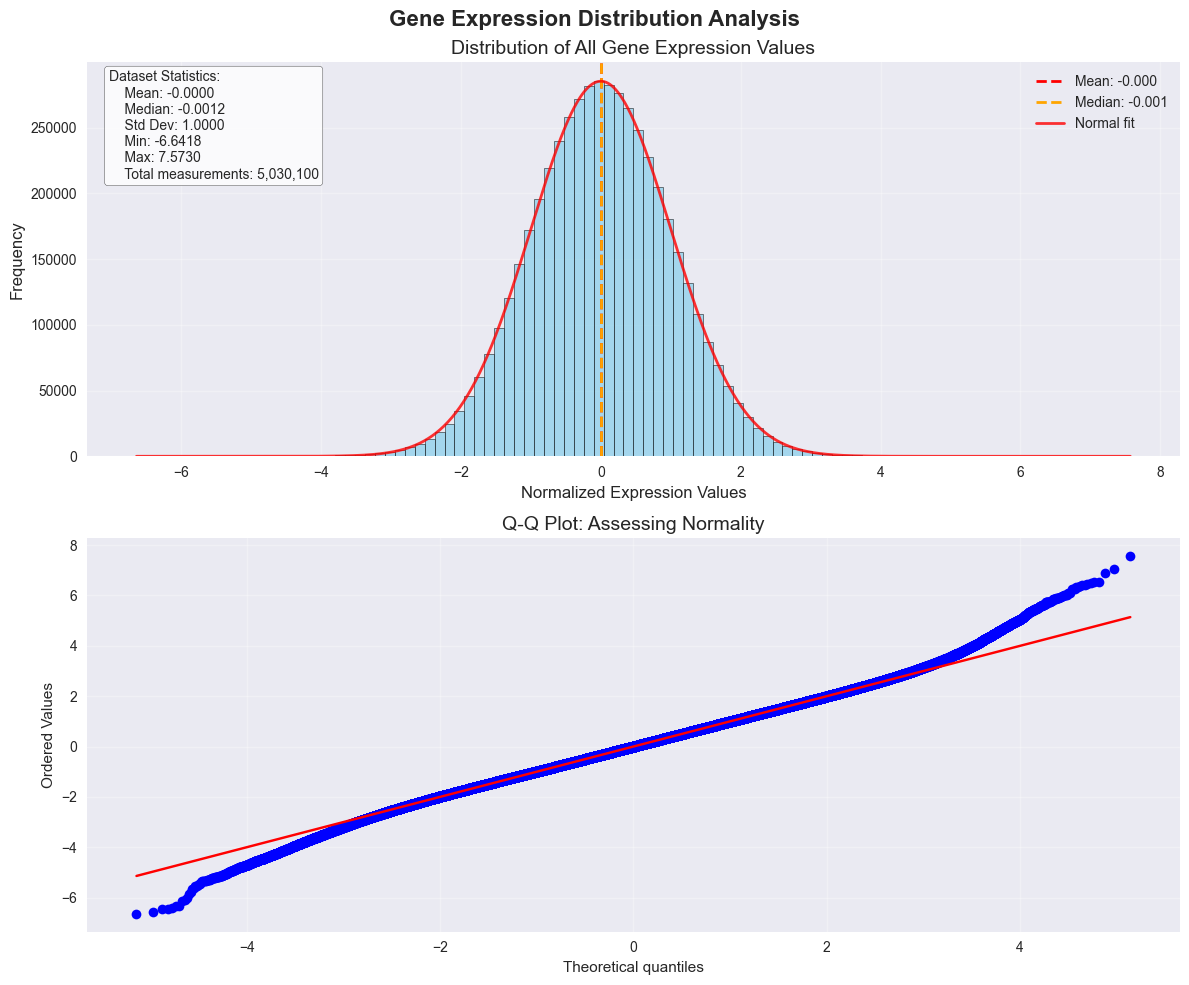


DATA QUALITY ASSESSMENT
Mean: -0.0000
GOOD: Data appears to be properly centered around zero

Skewness: -0.0007
GOOD: Distribution is approximately symmetric

Kurtosis: 0.2153
GOOD: Distribution has normal tail behavior

Potential outliers: 42,760 (0.85%)
GOOD: Low percentage of outliers

RECOMMENDATIONS FOR VAE DESIGN
Your data appears well-normalized for VAE input
Standard VAE architecture should work well
Recommended VAE latent dimension range: 70-224

SAMPLE-LEVEL ANALYSIS
Sample mean range: -0.4382 to 0.6902
Sample std range: 0.7817 to 1.3792

Potentially problematic samples: 5
Samples to investigate: ['GSM1406045', 'GSM1406065', 'GSM1406110', 'GSM1406114', 'GSM1406118']


In [20]:
main('C:/Users/diego/Projects2025/neurocardiac_project/data/processed_data/stroke_processed/results/GSE58294/expression_normalized.csv')